In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

In [3]:
#df_wos = pd.read_csv("control/ccs_webOfScience.csv", index_col=0, skipinitialspace=True)
#df_sp = pd.read_csv("control/ccs_scopus.csv", index_col=0, skipinitialspace=True)

df_wos = pd.read_csv("../datasets/controls_title_only/webOfScience_fix.csv", skipinitialspace=True)
df_sp = pd.read_csv("../datasets/controls_title_only/scopus_fix.csv", skipinitialspace=True)

In [4]:
df_wos["title"] = df_wos["title"].str.replace('[^\w\d]','', regex=True).str.lower()
df_sp["title"] = df_sp["title"].str.replace('[^\w\d]','', regex=True).str.lower()

df_wos["authors"] = df_wos["authors"].str.lower()
df_sp["authors"] = df_sp["authors"].str.lower()

df_wos["doi"] = df_wos["doi"].str.lower()
df_sp["doi"] = df_sp["doi"].str.lower()

In [5]:
df_doi = df_wos.merge(df_sp, how="inner", on="doi", suffixes=("_wos","_sp"))
df_doi = df_doi[~df_doi["doi"].isnull()]

In [6]:
df_title = df_wos.merge(df_sp, how="inner", on="title", suffixes=("_wos","_sp"))
df_title = df_title[~df_title["title"].isnull()]
df_title["doi_match"] = df_title["doi_wos"] == df_title["doi_sp"]
df_title = df_title[~df_title["doi_match"]]

In [7]:
df_overlap = pd.concat([df_doi.drop(['title_sp','authors_sp','year_sp'], axis=1).rename(columns={'title_wos':'title'}),
                        df_title.drop(['doi_sp','authors_sp','year_sp','doi_match'], axis=1).rename(columns={'doi_wos':'doi'})]).reset_index(drop=True)

In [8]:
df_agg = df_doi.groupby('year_wos').size().rename('doi_matches').reset_index().set_index('year_wos')
df_agg = df_agg.merge(df_title.groupby("year_wos").size().rename('title_matches').reset_index().set_index('year_wos')
                      , on='year_wos', how='outer') \
                .merge(df_wos.groupby('year').size().rename('wos_docs').reset_index().set_index('year')
                      , how='outer', left_index=True, right_index=True) \
                .merge(df_sp.groupby('year').size().rename('sp_docs').reset_index().set_index('year')
                       , how='outer', left_index=True, right_index=True).fillna(0)

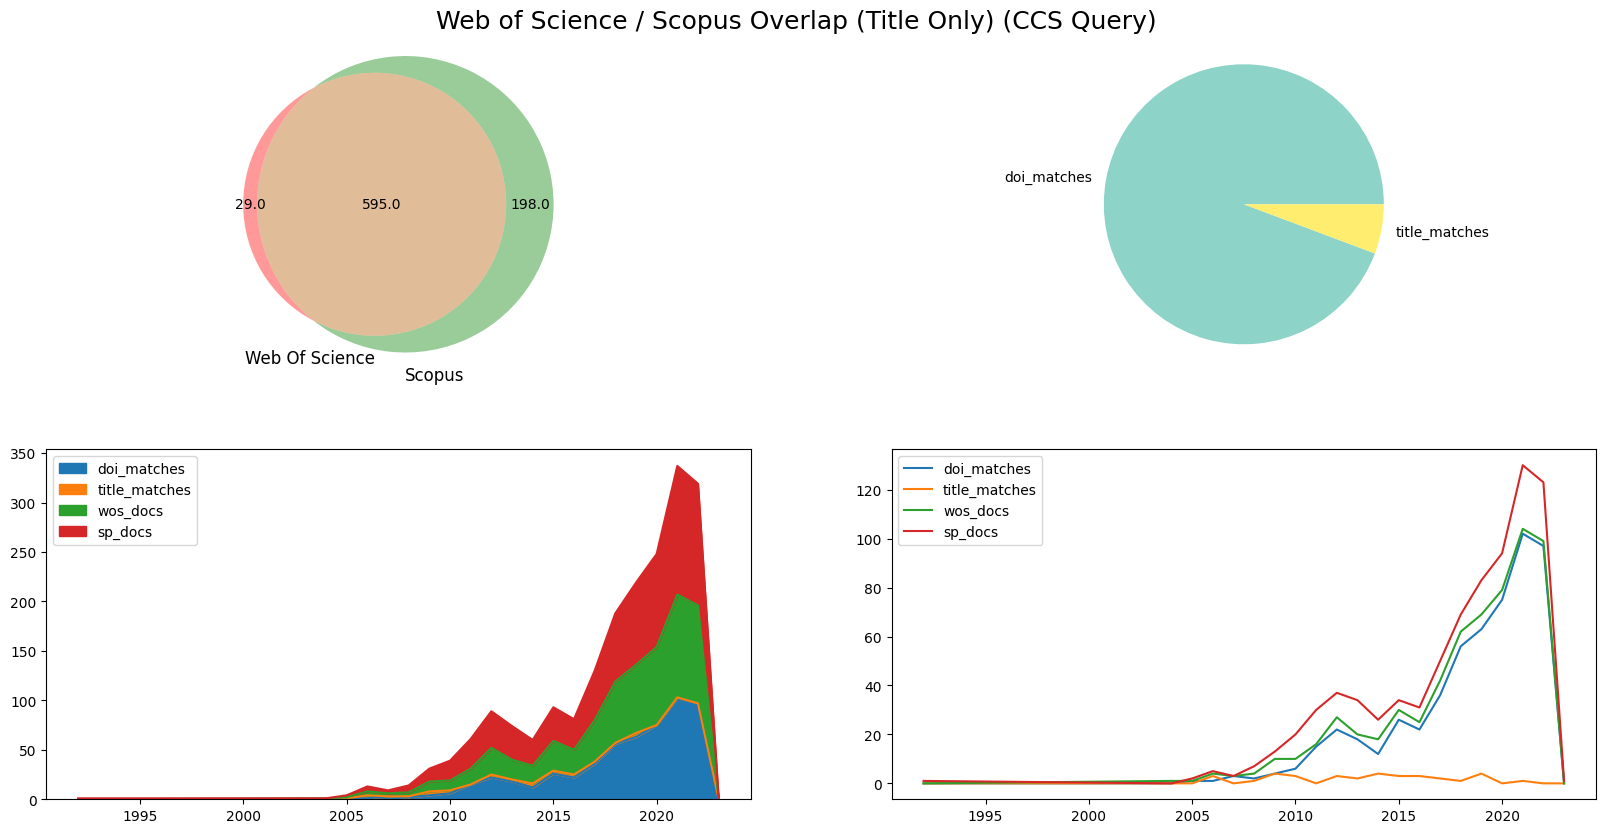

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

matches = df_agg.agg('sum')['doi_matches'] + df_agg.agg('sum')['title_matches']
wos = df_agg.agg('sum')['wos_docs']
sp = df_agg.agg('sum')['sp_docs']

venn2(subsets = (wos - matches,sp - matches,matches), ax=axes[0,0], set_labels=('Web Of Science', 'Scopus', ''))
df_agg[['doi_matches','title_matches']].agg('sum').plot(kind='pie', ax=axes[0,1], colormap='Set3', ylabel="")
df_agg.plot(kind='area', stacked=True, ax=axes[1,0])
df_agg.plot(kind='line', ax=axes[1,1])

plt.suptitle("Web of Science / Scopus Overlap (Title Only) (CCS Query)", fontsize=18, y=0.9)
plt.savefig("/home/joe/repos/mcc/engineEval/db_comparison/local/viz/controls_overlap_title_only.png", bbox_inches="tight")

In [10]:
# Semantic Scholar #

#df_s2 = pd.read_csv('s2_results_nr.tsv', sep='\t')
df_s2 = pd.read_csv("../local/query/output/s2_title_scan_fix.tsv", sep='\t')
df_s2["title"] = df_s2["title"].str.replace('[^\w\d]','', regex=True).str.lower()
df_s2["doi"] = df_s2["doi"].str.lower()

In [11]:
# I removed abstract for the title search

df_s2_doi = df_overlap.merge(df_s2[~df_s2['doi'].isnull()], on='doi', how='inner') \
    .drop(['title_y','authors_wos'], axis=1) \
    .rename(columns={'title_x':'title', 'year_wos' : 'year'})

df_s2_ttl = df_overlap.merge(df_s2[~df_s2['title'].isnull()], on='title', how='inner') \
    .drop(['authors_wos'], axis=1) \
    .rename(columns={'doi_x':'doi', 'year_wos' : 'year'})

df_s2_overlap = pd.concat([df_s2_doi, df_s2_ttl[~(df_s2_ttl['doi'] == df_s2_ttl['doi_y'])].drop(['doi_y'], axis=1)]).reset_index(drop=True)

In [ ]:
df_s2_wos_doi = df_wos.merge(df_s2[~df_s2['doi'].isnull()], on='doi', how='inner') \
    .drop(['title_y'], axis=1) \
    .rename(columns={'title_x':'title', 'year_x' : 'year'})

df_s2_wos_ttl = df_wos.merge(df_s2[~df_s2['title'].isnull()], on='title', how='inner') \
    .rename(columns={'doi_x':'doi', 'year_wos' : 'year'})

df_s2_wos = pd.concat([df_s2_wos_doi, df_s2_wos_ttl[~(df_s2_wos_ttl['doi'] == df_s2_wos_ttl['doi_y'])].drop(['doi_y'], axis=1)]).reset_index(drop=True)

In [ ]:
df_s2_sp_doi = df_sp.merge(df_s2[~df_s2['doi'].isnull()], on='doi', how='inner') \
    .drop(['title_y'], axis=1) \
    .rename(columns={'title_x':'title', 'year_x' : 'year'})

df_s2_sp_ttl = df_sp.merge(df_s2[~df_s2['title'].isnull()], on='title', how='inner') \
    .rename(columns={'doi_x':'doi', 'year_wos' : 'year'})

df_s2_sp = pd.concat([df_s2_sp_doi, df_s2_sp_ttl[~(df_s2_sp_ttl['doi'] == df_s2_sp_ttl['doi_y'])].drop(['doi_y'], axis=1)]).reset_index(drop=True)

In [ ]:
df_s2_agg = df_s2_overlap.groupby('year').size().rename('overlapped_matches').reset_index().set_index('year')
df_s2_agg = df_s2_agg.merge(df_s2_wos.groupby("year").size().rename('wos_matches').reset_index().set_index('year')
                      , on='year', how='outer') \
                .merge(df_s2_sp.groupby('year').size().rename('sp_matches').reset_index().set_index('year')
                       , on='year', how='outer') \
                .merge(df_wos.groupby('year').size().rename('wos_docs').reset_index().set_index('year')
                      , how='outer', left_index=True, right_index=True) \
                .merge(df_sp.groupby('year').size().rename('sp_docs').reset_index().set_index('year')
                       , how='outer' , left_index=True, right_index=True) \
                .merge(df_s2.rename(columns={'publication_year' : 'year'}).groupby('year').size().rename('s2_docs').reset_index().set_index('year')
                       , on='year', how='outer') \
                       .fillna(0)

<AxesSubplot:xlabel='year'>

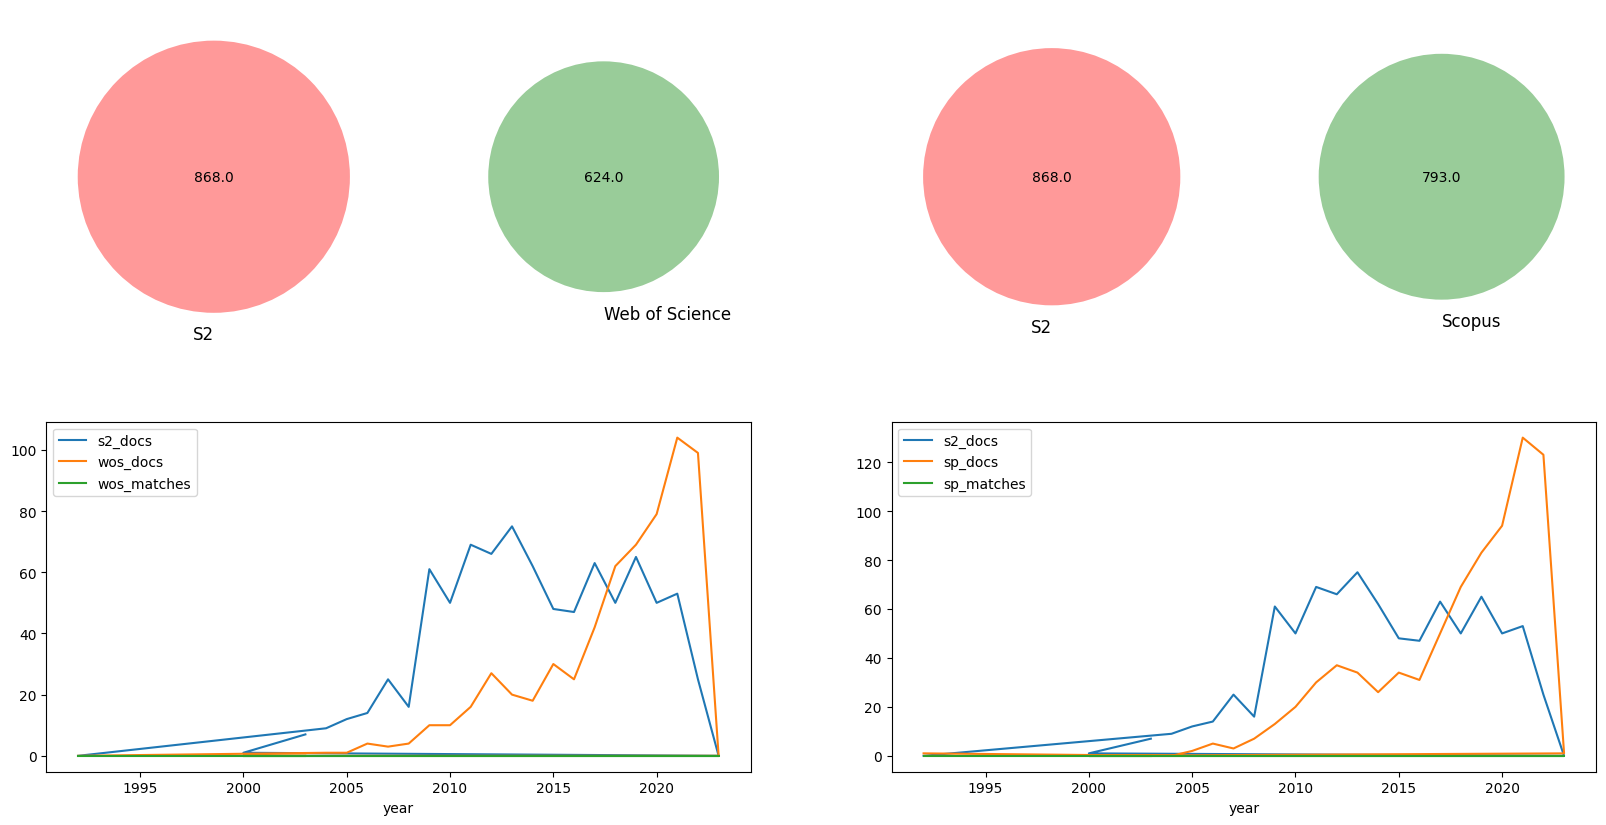

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

s2_wos_matches = df_s2_agg.agg('sum')['wos_matches']
s2_sp_matches = df_s2_agg.agg('sum')['sp_matches']
s2_overlap_matches = df_s2_agg.agg('sum')['overlapped_matches']
wos = df_s2_agg.agg('sum')['wos_docs']
s2 = df_s2_agg.agg('sum')['s2_docs']
sp = df_s2_agg.agg('sum')['sp_docs']

venn2(subsets = (s2,wos,s2_wos_matches), ax=axes[0,0], set_labels=('S2', 'Web of Science', ''))
venn2(subsets = (s2,sp,s2_sp_matches), ax=axes[0,1], set_labels=('S2', 'Scopus'))

df_s2_agg[['s2_docs','wos_docs','wos_matches']].plot(kind='line', ax=axes[1,0])
df_s2_agg[['s2_docs','sp_docs','sp_matches']].plot(kind='line', ax=axes[1,1,])

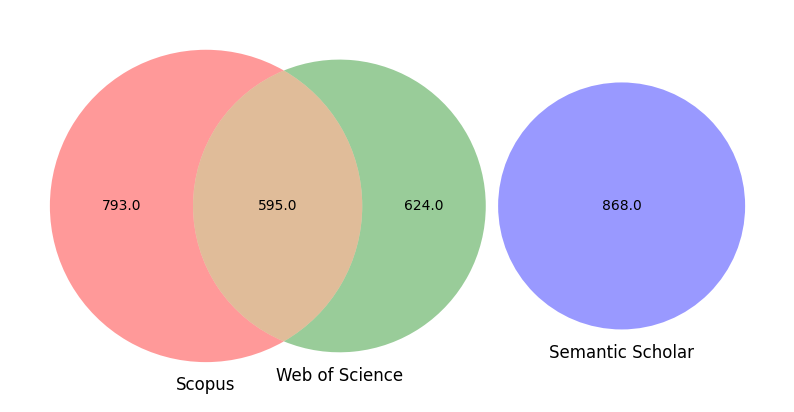

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

venn3(subsets = (sp
                 , wos
                 , matches - s2_overlap_matches
                 , s2 
                 , s2_sp_matches - s2_overlap_matches
                 , s2_wos_matches - s2_overlap_matches
                 , s2_overlap_matches
                ), set_labels = ('Scopus', 'Web of Science', 'Semantic Scholar'), ax=axes)

In [245]:
df_venn3[df_venn3["is_s2"] & ~df_venn3["is_sp"] & ~df_venn3["is_wos"]]

,doi,title,is_s2,is_sp,is_wos
0,10.1080/14693062.2015.1094730,usinstitutionalpathwaystocleancoalandshalegasl...,True,False,False
1,10.3997/2214-4609.20131605,studyofrecordedseismicityattheinsalahalgeriaca...,True,False,False
2,NaN,carboncaptureandstorageccsanditspotentialrolet...,True,False,False
3,10.2139/ssrn.3819721,experimentalbasedco2transportspecificationensu...,True,False,False
4,NaN,NaN,True,False,False
...,...,...,...,...,...
2531,NaN,technicalreviewofvarioussourcesofenergyproduct...,True,False,False
2532,10.1080/02757540.2017.1396319,co2leakagesimulationeffectsofthephdecreaseonfe...,True,False,False
2533,NaN,productionoffusedglassandproductionofhighpurit...,True,False,False
2534,NaN,prospectsforcarboncaptureandstoragetechnologies,True,False,False


In [248]:
df_venn3.to_csv("/home/joe/mcc/overlap_frame.tsv", sep="\t")

In [29]:
# documents missing abstracts and documents missing titles from S2
# title only query

,corpus_id,doi,title,publication_year,citation_count
0,100087343,10.1049/etr.2016.0172,introductiontocarboncaptureandstorage,2012.0,3
1,100239907,10.1016/j.ijggc.2016.09.013,performanceofcoriolisflowmetersinco2pipelinesw...,2016.0,13
2,100618917,10.1080/10916466.2015.1107847,accuratepredictionofpropertiesofcarbondioxidef...,2016.0,11
3,100893740,10.1016/j.jct.2016.03.026,thermodynamicpropertiesofaco2richmixtureco2ch3...,2016.0,4
4,100901865,10.1021/ef502667d,gasolinefromcoalandorbiomasswithco2captureands...,2015.0,15
...,...,...,...,...,...
865,99740592,NaN,coalwithcarboncaptureandstorageanessentialbrid...,2006.0,0
866,99877321,10.7916/d87m0dnw,bioenergywithcarboncaptureandstoragebeccsprodu...,2017.0,0
867,99841870,10.5771/9783845254586_532,23auswirkungendeseurechtsaufdenklimaschutzzuru...,2014.0,0
868,99996471,NaN,carboncaptureandstorageusingmgoaerogels,2013.0,0
